In [1]:
####This method is designed to normalize the distance effect in Hi-C data
####It separates the backgrounds from peaks first, then adjust difference between adjacent distance with foldchange from background values only
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas
import scipy

In [3]:
%time exphic2 = np.load('/Users/linan/Desktop/HiCtest/chr18_10kb.npy')

CPU times: user 2.28 ms, sys: 773 ms, total: 775 ms
Wall time: 1.42 s


In [4]:
##load the loops and use it as a validation in further analysis
loop = np.loadtxt('/Users/linan/Desktop/HiCtest/Gm12878.chr18.loops') 

yloop = (loop[:,2]-loop[:,1])/10000
yloop = yloop.astype(int)

lloop = loop[:,1]/10000
lloop = lloop.astype(int)
rloop = loop[:,2]/10000
rloop = rloop.astype(int)

xloop = exphic2[lloop,rloop]+exphic2[lloop,rloop+1]

In [5]:
##load the TADs and use it as a validation in further analysis
Arrowhead = pandas.read_table('/Users/linan/Box/TADcalling/Arrowhead.Gm12878',sep='\t',header=None)
tad=Arrowhead.loc[Arrowhead[0]=='18',0:2].values
ytad = (tad[:,2]-tad[:,1])/10000
ytad = ytad.astype(int)

ltad = tad[:,1]/10000
ltad = ltad.astype(int)
rtad = tad[:,2]/10000
rtad = rtad.astype(int)

xtad = exphic2[ltad,rtad]+exphic2[ltad,rtad+1]

In [7]:
###main function to convert interaction frequency into T
def twodisncis (mat1,dis1,dis2):
    hic1 = np.diag(mat1,k=dis1)[:-abs(dis2-dis1)]
    hic2 = np.diag(mat1,k=dis2)
    ind = list(np.unique(hic1+hic2))
    div = dict((key, [0,0]) for key in ind)###store all values in dict with key as unique sum and value as interaction frequency on two distance
    for j in range(0,len(hic1)):
        div[(hic1[j]+hic2[j])][0] += float(hic1[j])
        div[(hic1[j]+hic2[j])][1] += float(hic2[j])
    return div

In [9]:
####convert the hi-c matrix into three vectors: x (all possible T), y (genomic distance) and z (fold change across two distance at each T)
%time
y=[]
x=[]
z=[]
d1 = []
d2 = []
for j in range(0,499):
    d = twodisncis(exphic2+1,j,j+1)
    for i in d.keys():
        u = d[i]
        if u[0] != 0 and u[1] != 0:
            x.append(i)
            y.append(j)
            z.append(u[0]/float(u[1]))
            d1.append(u[0])
            d2.append(u[1])
x = np.array(x)
y = np.array(y)
z = np.log10(np.array(z))
d1 = np.array(d1)
d2 = np.array(d2)

CPU times: user 9 µs, sys: 5 µs, total: 14 µs
Wall time: 18.8 µs


In [10]:
###store the three vectors into matrix, with x as col numbers, y as row numbers and z as value in each cell
mat = np.full([500, int(np.max(x)+1)], np.nan)

for q in range(0,len(x)):
    mat[int(y[q]),int(x[q])]=z[q]

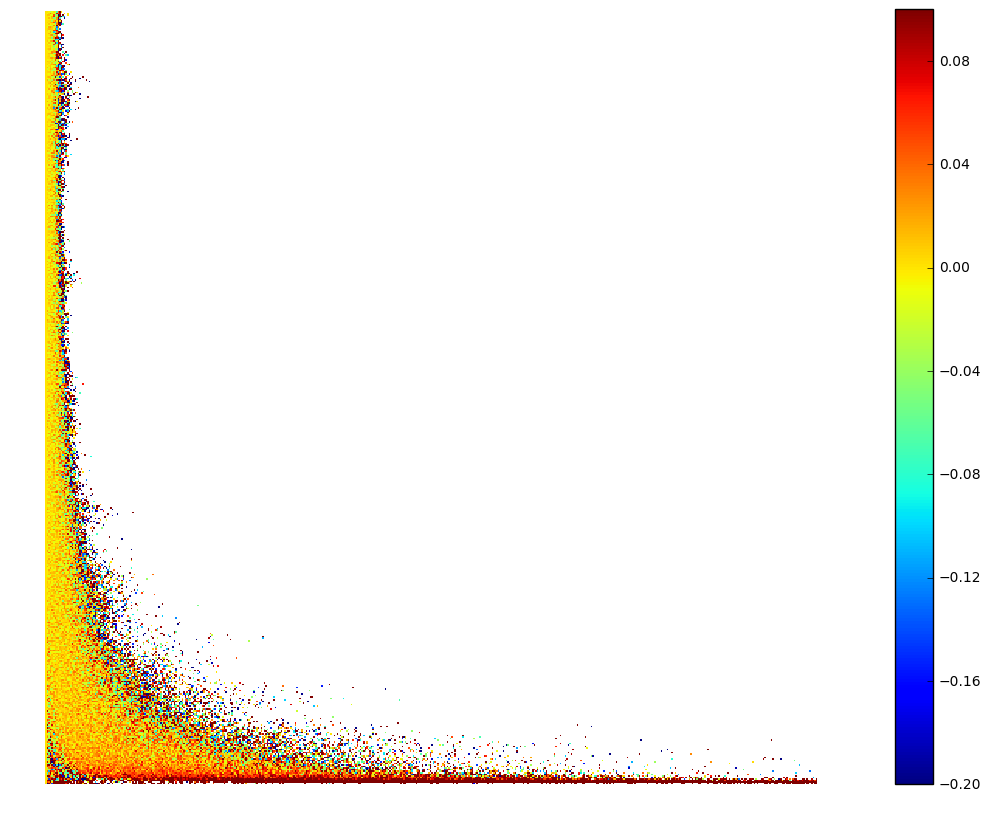

In [12]:
###Plot the matrix and we can see there is a clear separation. The yellow part in the middle are the backgrounds we want to focus
fig = plt.figure(0,figsize=(20,10))
cmap = matplotlib.cm.jet
cmap.set_bad('white',1.)
plt.imshow(mat[:,0:500], cmap=cmap, interpolation='none', origin='lower',vmin = -0.2, vmax = 0.1)
#plt.scatter(xtad,ytad,c='m',linewidths=0.1)
#plt.scatter(xloop,yloop,c='b',linewidths=0.1)
plt.axis('off')
plt.colorbar()
plt.show()

In [13]:
##Now let's fit two lines to get the middle part
x1 = np.where(abs(mat)>=np.std(z)/2)
nn = x1[0]*x1[1]

In [14]:
x11=x1[0][np.where(nn>=1000)]
x22=x1[1][np.where(nn>=1000)]
x33=x1[0][np.where(nn<1000)]
x44=x1[1][np.where(nn<1000)]

In [15]:
x11u = np.unique(x11)
x22f = np.array([])
x11f = np.array([])
for o in x11u:
    x22f=np.append(x22f,np.min(x22[np.where(x11==o)]))
    x11f=np.append(x11f,o)

In [16]:
x33u = np.unique(x33)
x44f = np.array([])
x33f = np.array([])
for o in x33u:
    x44f=np.append(x44f,np.max(x44[np.where(x33==o)]))
    x33f=np.append(x33f,o)

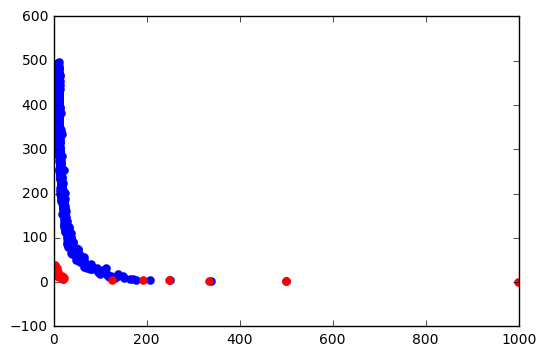

In [17]:
plt.figure(4)
plt.scatter(x22f,x11f, s=10, edgecolor='b',label='test',linewidth=3)
plt.scatter(x44f,x33f, s=10, edgecolor='r',label='test',linewidth=3)
plt.xlim(0,1000)
plt.show()

In [18]:
import statsmodels.api as sm
from scipy.interpolate import interp1d
lowess = sm.nonparametric.lowess
lfit = lowess(x22f, x11f,frac=1./10)
f = interp1d(list(zip(*lfit))[0], list(zip(*lfit))[1], bounds_error=False)

In [19]:
lfit2 = lowess(x44f, x33f,frac=1./10)
f2 = interp1d(list(zip(*lfit2))[0], list(zip(*lfit2))[1], bounds_error=False)

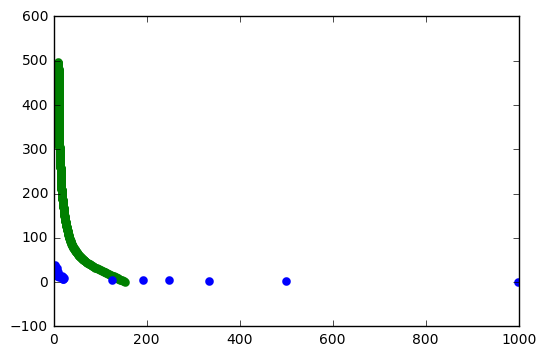

In [20]:
plt.figure(5)
plt.scatter(lfit[:,1],x11f, s=10, edgecolor='g',label='far',linewidth=3)
plt.scatter(lfit2[:,1],x33f, s=10, edgecolor='b',label='near',linewidth=3)
plt.xlim(0,1000)
plt.show()

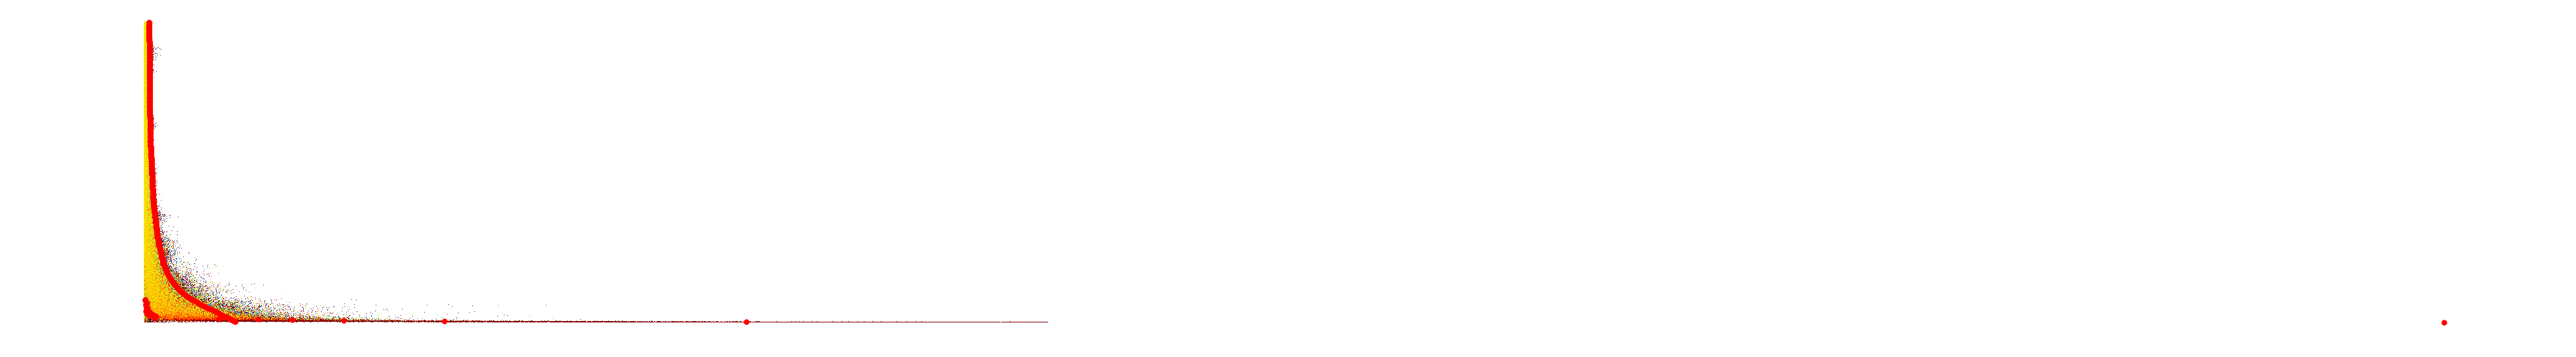

In [21]:
###Here are the two red lines which can separate the backgrounds from peaks and noise
fig = plt.figure(10,figsize=(50,25))
plt.imshow(mat[:,0:1500], cmap='jet', interpolation='none', origin='lower',vmin = -0.2, vmax = 0.1)
plt.scatter(lfit[:,1],x11f, s=10, edgecolor='r',label='test',linewidth=3)
plt.scatter(lfit2[:,1],x33f, s=10, edgecolor='r',label='near',linewidth=3)
plt.axis('off')
plt.show()

In [22]:
###Then we can calculate the foldchange iteratively between distances
r=np.array([])
for j in range(0,500):
    indinx = np.where(y==j)[0]
    t1 = 0
    t2 = 0
    if np.isnan(f(j)):
        tmax = 0
    else:
        tmax = f(j)
    if np.isnan(f2(j)):
        tmin = 0
    else:
        tmin = f2(j) 
    for i in indinx:     
        if x[i]<=tmax and x[i]>=tmin:
            t1 += d1[i]
            t2 += d2[i]
    r=np.append(r,(t1+0.01)/float(t2+0.01))

In [23]:
####Remove the low frequent and high frequent regions
testmat = np.copy(exphic2)
for j in range(10,500):
    if np.isnan(f(j)):
        tmax = 0
    else:
        tmax = f(j)
    if np.isnan(f2(j)):
        tmin = 0
    else:
        tmin = f2(j)
    hic1 = np.diag(exphic2,k=j)[:-abs(1)]
    hic2 = np.diag(exphic2,k=j+1)
    indtest = hic1 + hic2
    n=0
    for i in range(0,len(indtest)):
        if indtest[i] <= tmin:
            testmat[i,min(i+j,np.shape(testmat[0]))]=0
            testmat[min(i+j,np.shape(testmat[0])),i]=0
        elif indtest[i] >= tmax:
            testmat[i,min(i+j,np.shape(testmat[0]))]=2
            testmat[min(i+j,np.shape(testmat[0])),i]=2
        else:
            testmat[i,min(i+j,np.shape(testmat[0]))]=1
            testmat[min(i+j,np.shape(testmat[0])),i]=1            
            n+=1
    #print float(n)/len(indtest)

In [24]:
####correct the original matrix with foldchange
def bydiscorrection (mat1,lowerb, totaldis, rlist):
    m,n=np.indices(mat1.shape)
    newm = np.zeros(mat1.shape)
    for i in range(lowerb+1,totaldis):
        hic1 = mat1[m==n-i]
        newm[m==n-i] = hic1*np.prod(rlist[lowerb:(i+1)])
        newm[m==n+i] = hic1*np.prod(rlist[lowerb:(i+1)])
    return newm

In [377]:
r[r<1]=1

In [189]:
def loopvsadjacent (hicmat,looplist,winsize,dismin):
    looplist = looplist[(looplist[:,2]-looplist[:,1])>dismin*10000]
    loopint = hicmat[looplist[:,1].astype(int)/10000,looplist[:,2].astype(int)/10000]
    adjint = np.zeros((len(loopint)))
    for i in range(0-winsize,winsize+1):
        for j in range(0-winsize,winsize+1):
            if i != 0 and j!=0:
                adjint += hicmat[looplist[:,1].astype(int)/10000+i,looplist[:,2].astype(int)/10000+j]
    fold = loopint*((2*winsize+1)**2-1)/adjint
    return fold

In [190]:
rawf = loopvsadjacent(exphic2,loop,2,5)
ncisf = loopvsadjacent(adjmat,loop,2,5)
distf = loopvsadjacent(divmeanmat,loop,2,5)

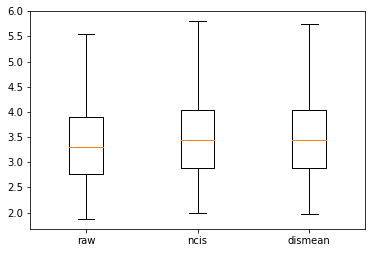

In [191]:
####Evaluate our result by calculating the difference of loops against surrounding regions
plt.figure(5)
plt.boxplot([rawf,ncisf,distf],0, '')
plt.xticks([1,2,3],
           ["raw","ncis","dismean"])
plt.show()